In [3]:
from DTM_filtrations import *

import gudhi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.decomposition import PCA

from scipy import spatial
#np.random.seed(42)

# 1. Algorithm

## 1.1 Normalized local covariance matrices

In [4]:
def NormalizedLocalCovarianceMatrices(X, r):
    '''
    ----------------------------------------
    Compute the normalized covariance matrices at scale r of the set X.
    
    Input:
        X (np.array): size Nxn, representing N points in R^n.
        r (float): a positive parameter.
    
    Output: 
        NormLocCovMat (np.array): size Nx(nxn), the normalized covariance matrices.
    ------------------------------------------
    '''
    N = np.shape(X)[0]
    n = np.shape(X)[1]
    
    tree = spatial.KDTree(X)
    LocCovMat = np.zeros((N,n,n))
    NormLocCovMat = np.zeros((N,n,n))
    for i in range(N):
        x = X[i, :]
        ind = tree.query_ball_point(x, r)
        k = len(ind)    
        M = 0
        for j in range(k):
            z = X[i, :] - X[ind[j], :]
            M = M + np.outer(z,z)
        M = M/k
        LocCovMat[i,:,:] = M
    NormLocCovMat = LocCovMat/r**2
    return NormLocCovMat

Connection between points and related matrices (lifted set)

In [5]:
def Lifting(X, r, gamma):
    '''
    Compute the set lifted set X_check associated to X. It is the set of pairs 
    (x,A), where x is a point of X, and A the associated local covariance matrix.
    
    Input:
        X (np.array): size Nxn, representing N points in R^n.
        r (float): a positive parameter.
        gamma (float): a non-negative parameter.
    
    Output: 
        labels ()
        X_check (np.array): size Nx(n+n^2), representing N points in R^(n+n^2).
    '''
    N = np.shape(X)[0]
    n = np.shape(X)[1]    
    NormLocCovMat = NormalizedLocalCovarianceMatrices(X,r)
    X_check = np.zeros((N, n+n**2))
    for i in range(N):
        X_check[i, 0:n] = X[i,:]
        X_check[i, n:(n+n**2)] = gamma*np.matrix.flatten(NormLocCovMat[i,:,:])
    return X_check

## 1.2 Quantization with tangent spaces

In [6]:
def initialize_centroids(X, k):
    # Randomly select k initial centroids
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

def assign_clusters(X, centroids):
    # Assign each data point to the nearest centroid
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

def update_centroids(X, labels, k):
    # Update centroids to be the mean of the points in each cluster
    centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    return centroids

def k_quantizers(X_check, k, max_iters=1000):
    '''
    ----------------------------------------
    Compute optimal k-quantizers with the normalized covariance matrices.
    
    Input:
        X_check (np.array): size Nx(n^2), representing N points in R^n with their normalized covariance matrices.
        k (int): a positive integer.
    
    Output: 
        centroids (np.array): size Nx(n+n^2), the normalized covariance matrices.
    ------------------------------------------
    '''
    centroids = initialize_centroids(X_check, k)
    for _ in range(max_iters):
        labels = assign_clusters(X_check, centroids)
        new_centroids = update_centroids(X_check, labels, k)
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    centroids = centroids[:,0:2]
    return labels, centroids

# 2. An application in simulated samples

## 2.1 Symbol "Infinite"

In [7]:
def SampleInfinite(N_observation = 100, scale = 0.01):
    I = 2*np.pi*np.linspace(0,1,N_observation)
    #Z = (np.random.rand(2, N_observation)*2-1)*scale
    Z = [0, 0]
    X = np.sin(I)+Z[0]
    Y = np.sin(I) * np.cos(I)+Z[1]
    data = np.stack((X,Y)).transpose()
    return data

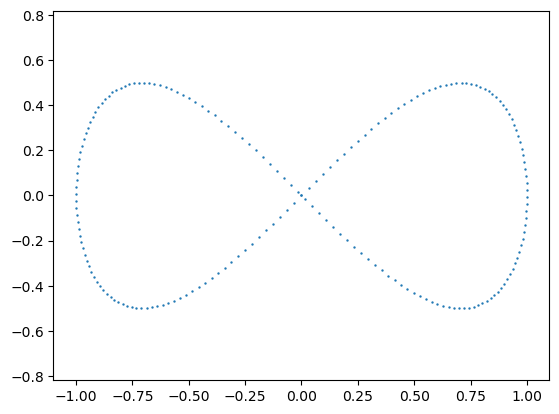

In [8]:
N_observation = 200
data = SampleInfinite(N_observation)
plt.scatter(data[:,0],data[:,1], s=0.5)
plt.axis('equal')
plt.show()

In [9]:
r = 0.05
gamma = 2
data_check = Lifting(data, r, gamma)
X_local_covMatrix = NormalizedLocalCovarianceMatrices(data, r)

#### a representation of Normalized Local Covariance Matrices

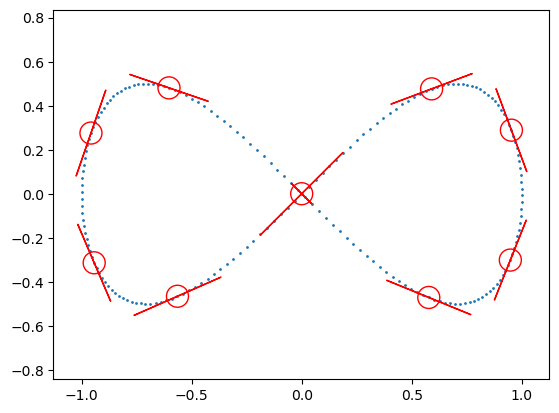

In [10]:
eigenvalues, eigenvectors = np.linalg.eig(X_local_covMatrix)
points = data
plt.scatter(data[:,0], data[:,1], s = 1)
length = len(eigenvalues[0])
for i in [0, 20,40,60,80,120,140,160,180]:
    for j in range(length):
        vector = eigenvectors[i].T[j]
        value = eigenvalues[i][j]
        plt.arrow(points[i, 0], points[i, 1], -vector[0]*value, -vector[1]*value, head_width=0, head_length=0, color='red')
        plt.arrow(points[i, 0], points[i, 1], vector[0]*value, vector[1]*value, head_width=0, head_length=0, color='red')
    center = (points[i, 0], points[i, 1])
    circle = Circle(center, r, color='r', fill=False)  # creat circle with radius r
    plt.gca().add_patch(circle)
plt.axis('equal')
plt.show()

#### a representation of lifed spaces projected in $\mathbb{R}^3$

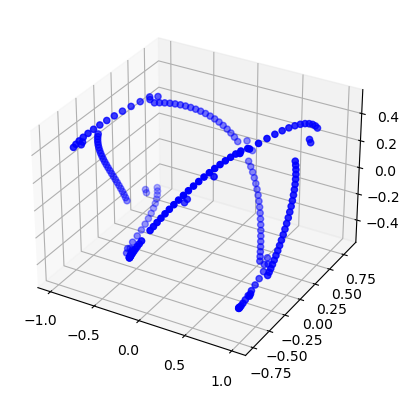

In [11]:
pca = PCA(n_components=3)
x_1 = pca.fit_transform(data_check)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_1[:, 0], x_1[:, 1], x_1[:, 2], c='b', marker='o')
#ax.view_init(45, 90)
plt.show()

#### utilization of quantizers to cluster points

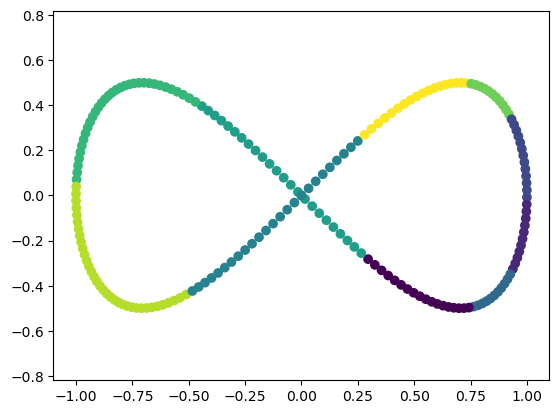

In [12]:
k = 10
labels, centroids = k_quantizers(data_check, k)
plt.scatter(data_check[:,0], data_check[:,1], c = labels)
#plt.scatter(centroids[:,0], centroids[:,1],c="red")
plt.axis('equal')
plt.show()

#### Comparison with k-means

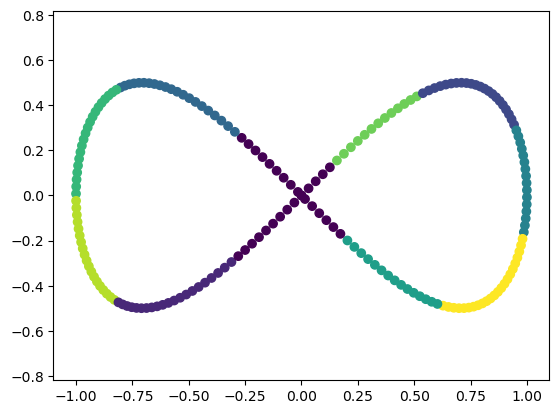

In [13]:
labels, centroids = k_quantizers(data, k)
plt.scatter(data[:,0], data[:,1], c = labels)
#plt.scatter(centroids[:,0], centroids[:,1],c="red")
plt.axis('equal')
plt.show()

## 2.2 Randomly points

In [14]:
def SampleOnLemniscate(N_observation = 100, scale = 0.01):
    I = 2*np.pi*np.linspace(0,1,N_observation)
    Z = (np.random.rand(2, N_observation)*2-1)*scale
    #Z = [0, 0]
    X = np.sin(I)+Z[0]
    Y = np.sin(I) * np.cos(I)+Z[1]
    data = np.stack((X,Y)).transpose()
    return data

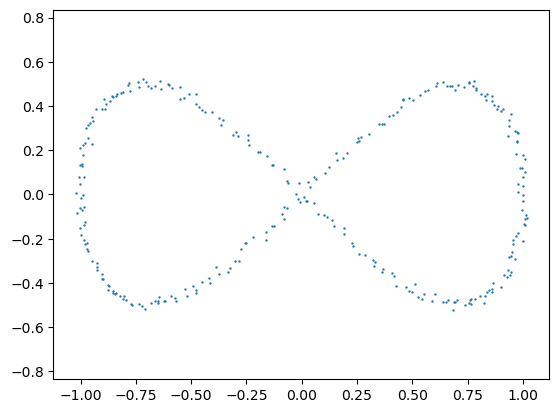

In [31]:
N_observation = 300
data2 = SampleOnLemniscate(N_observation, scale = 0.025)
plt.scatter(data2[:,0],data2[:,1], s=0.5)
plt.axis('equal')
plt.show()

In [32]:
r = 0.23
gamma = 2
data2_check = Lifting(data2, r, gamma)
X_local_covMatrix = NormalizedLocalCovarianceMatrices(data2, r)

#### utilization of quantizers to cluster points

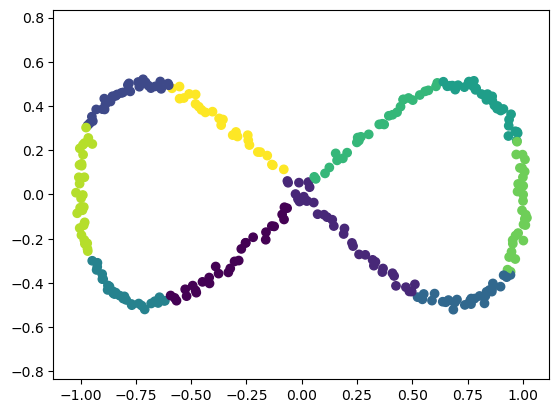

In [33]:
k = 10
labels, centroids = k_quantizers(data2_check, k)
plt.scatter(data2_check[:,0], data2_check[:,1], c = labels)
#plt.scatter(centroids[:,0], centroids[:,1],c="red")
plt.axis('equal')
plt.show()

#### Comparison with k-means

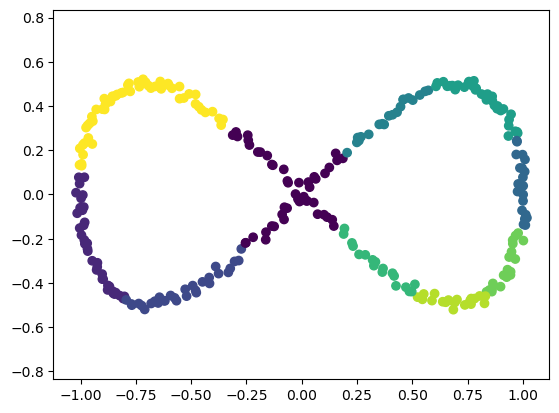

In [34]:
labels, centroids = k_quantizers(data2, k)
plt.scatter(data2[:,0], data2[:,1], c = labels)
#plt.scatter(centroids[:,0], centroids[:,1],c="red")
plt.axis('equal')
plt.show()